In [1]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from xgboost import plot_tree
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import multilabel_confusion_matrix

import json
import glob
import os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
loadFromMerged=True
loadFromIndexes= False
Mapper='S'
IgnoreEmpty= True
FoldID ="1"
Epoch_count=100
Batch_size=5000


valid_event_values = set(['on','off','open','closed','locked','unlocked','XXX'])


In [3]:
%run './utils.ipynb'

Using TensorFlow backend.


In [4]:
def print_info(y_test, pred , classes , confidance=0.5, print_skf1=False, size= 500):
    
    counts = np.sum( y_test.astype(int) , axis=0)
    
    pred[pred>=confidance] = 1
    pred[pred<confidance] = 0
    
#     acc_wierd  =acc_match_wierd(y_test, pred)
    
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
      
    
    unknonw_index =-1

    tp = 0.00000001
    tn = 0.00000001
    fp =0.00000001
    fn = 0.00000001
    
    for index in range(len(classes)):
        if 'unknown' in classes[index]:
            unknonw_index = index
            continue
            
        tp += conf[index][1][1]
        tn += conf[index][0][0]
        fp += conf[index][0][1] 
        fn += conf[index][1][0]
        
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
    knowns_accs= [acc, recall, prec, F]
    print ("------------------------------------------------------------------------")
    index = unknonw_index
    tp += conf[index][1][1]
    tn += conf[index][0][0]
    fp += conf[index][0][1] 
    fn += conf[index][1][0]

    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    F= 2.0*( tp)/ (2*tp + fp + fn)
    
 
    all_accs =  [acc, recall, prec, F]
 
  
    return size, all_accs, knowns_accs
    
    

In [5]:
def clean_data( x_data, y_data , removeempty=True, Mapping='S'):

    #  mapps the input records to a integer array for the input
    def mapping_x( inp, includeDirection = False , TrimAt= 15 ):
        includeDirection=True
        if includeDirection:
            return np.array([ x["frame_length"] + 
            ('+' if x['packet_source']=='hub' else '-')  
            for x in inp ])
        else:
            # return np.array([ int(int(x["frame_length"])/10)*10  for x in inp ])
            return np.array([ x["frame_length"]  for x in inp ])

    def mapping_y_service(inp):
        return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

    def mapping_y_service_event(inp):
        return np.array(  list(set([ ("%s-%s"%( x["event"] ,x["val"] )).replace('unknown-','unknown') for x in inp])) if (len(inp )>0) else ["none"] )

    def mapping_y_device_service(inp):
        return np.array(  list(set([ "%s & %s"%( x["device"] ,x["event"] ) for x in inp])) if (len(inp )>0) else ["none"] )

    def mapping_y_full(inp):
        return np.array(  list(set([ "%s & %s & %s"%( x["device"] ,x["event"], x['val'] ) for x in inp])) if (len(inp )>0) else ["none"] )

    # print(y_data)
    cleans = [] 
    cleans = (sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] ))
    
    ret_x_data  = [x_data[x] for x in cleans]
    ret_y_data  = [y_data[x] for x in cleans] 
    
    # print( len(y_data), len(cleans) )
    # Mapping='SE'
    ret_x  = [ mapping_x(x) for x in ret_x_data ] 
    ret_y_s = [ mapping_y_service(y) for y in ret_y_data ]
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y_data ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y_data ]
    elif Mapping=='DS':
        ret_y  = [ mapping_y_device_service(y) for y in ret_y_data ]
    elif Mapping=='F':
        ret_y  = [ mapping_y_full(y) for y in ret_y_data ]
    return ret_x, ret_y, ret_x_data


In [6]:

def pre_process_raw( x_data,y_data, dim_size = 128, test = False, normalize = False ,classes=None, twoD= False, string =False ):
    #  y data 
    # """
    # this functino is in charge of preprocessing the records , the sourc e json contains a lot of extra stuff, this function tailors
    # the data and it fixes their lenghth
    # """
    global terms_dic
    # print(x_data)

    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    if classes and 'unknown' not in classes:
        classes.append('unknown') 
    classes = sorted(classes)  
    services=classes
    y_data_categorical = []  
    x_data_temp = [] 
    y_class_data = []
    print(classes)
    classes_count={}
    for i,labels in enumerate(y_data):
        classFound=False
        temp = np.zeros( len(classes) )
        # print(x)
        y_class=[]
        
        # if 'lock' in labels  and 'known' not in classes and test:
        #     print(labels)
        for label in labels :
            if 'unknown' in label  and len(labels)>1:
                continue
                
            if label in classes :#and (not test or classes_count.get(label,0)<1000):
                y_class.append(label)
                temp[ classes.index( label ) ] = 1
#                 if label!='unknown' and label!='ping':
#                     classes_count[label] = classes_count.get(label,0)+1
                classFound=True #if not classFound else classFound
                # if 'lock' in label and 'known' not in classes and test:
                #     print(label,classFound)

        
        
        if 'known' in classes and not classFound:
            temp[classes.index( 'known')] = 1                                
            y_class = labels
                         
        elif not classFound and not test:
            temp[classes.index('unknown')] = 1
            y_class.append('unknown')
            # print(y_class)
        
        

        if terms_dic and not test:          
            x_data_valid = np.array([seq for seq in x_data[i] if any([seq.split()[0] in terms_dic[lbl]for lbl in labels])])
        else:      
            x_data_valid=x_data[i]   
       
        if len(x_data_valid)>0 and len(y_class)>0:
            y_data_categorical.append( temp ) 
            # print(x_data_valid)
            x_data_temp.append(x_data_valid)
            y_class_data.append(' '.join(y_class))
            # if 'known' not in classes and test and 'lock' in labels:
            #     print(classFound,y_class,labels,x_data_valid)

    # print(x_data_temp)
    # print(y_data_categorical    )
    y_data_categorical = np.vstack(y_data_categorical)
    # print(y_data_categorical)
    x_data=x_data_temp
    # print(x_data)
    x_data_temp=[]
    temp = [] 
    
    for x in x_data:
        temp = [] #list(x)
        lst = list(x)
        temp = lst
        while len(temp)<dim_size:
            temp.extend(lst[:dim_size-len(lst)])
        # while dim_size - len(temp )   > len(lst):
        #     temp.extend(lst)

        # while len(temp) < dim_size:
        #     temp.append( 0 )
        if not string:
            x_data_temp.append(np.array(temp))
        else:
            x_data_temp.append(' '.join(list(map(str,temp))))
    #     # print(temp)
    # print(x_data)
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / (np.amax( x_data_temp) + 0.000000000001)
    else :
        x_data_temp = np.array(x_data_temp)
    
    print(x_data_temp.shape)
   
    return  x_data_temp ,y_data_categorical , y_class_data



In [7]:
count_eval_results = []
for t_len in range(50, 26000, 200):
    x_data= []
    y_data= []
    x_test = []
    y_test = []
    y_test_service= []
    x_train = []
    y_train = []
    test_names = []
    y_train_service=[]
    y_train_process_encoded=[]

    test_names = []

    add_to_trainig = [0,2]

    if loadFromMerged:
        print("in load from merged")
        for pick in sorted(glob.glob( '../files/iot_data_2020/train/hub_segments/*.json' )):
            fname  = os.path.basename(pick)
    #             test_names.append( fname )
            with open( os.path.join( '../files/iot_data_2020/train/hub_segments/', fname) ) as f:
                y_data = json.load(f)

            with open( os.path.join('../files/iot_data_2020/train/pcap_segments/', fname) ) as f:
                x_data = json.load(f)

            if len( y_data ) != len(x_data) :
                print( pick )
                continue

            x_t,y_t, y_t_s= clean_data( x_data, y_data, IgnoreEmpty , 
                                                     Mapping=Mapper )

            x_train.extend(x_t)
            y_train.extend(y_t)
            y_train_service.extend(y_t_s)

        print("loading from test files")
        files_path =  '../files/iot_data_2020/usecases/pcap_segments_final/*.json'
        test_y_dir = '../files/iot_data_2020/usecases/hub_segments_final/'
        test_x_dir =  '../files/iot_data_2020/usecases/pcap_segments_final/'

        test_files = sorted(glob.glob(files_path))
        print( "found files : " , len(test_files) )


    for pick  in test_files:
        if 'lock' in pick:
            continue
        fname  = os.path.basename(pick)
        test_names.append( fname )
        print(fname)
        with open( os.path.join(test_y_dir , fname) ) as f:
            y_data_test = json.load(f)

        with open( os.path.join(test_x_dir, fname) ) as f:
            x_data_test = json.load(f)


        t_x,t_y, t_z= clean_data( x_data_test, y_data_test, False , Mapping=Mapper)


        x_test.extend(t_x)
        y_test.extend(t_y)
        y_test_service.extend(t_z)
    x_train= x_train[:t_len]
    y_train= y_train[:t_len]
    
   # --------------------------------------------
       
        
        
    

    def predict_labels(classes,x_test_new,y_test_new,confidence):
        is_string=True
        print('predicting', classes)
        x_test_processed,y_test_processed_encoded, y_test_processed = pre_process_raw( x_test_new,
         y_test_new , dim_size, 
        test=True, normalize=False, classes=classes, string=is_string)

        def draw_xgb_tree():
            xgb = XGBClassifier()
            y = [labels.split(' ')[0] for labels in y_train_processed]
            # x_train_array = [map(int,x.split(' ')) for x in x_train_processed]      

            xgb.fit(x_train_processed, y)   
            # plot single tree
            plot_importance(xgb)
            plot_tree(xgb)
            plt.show()

        # draw_xgb_tree()
        def classify_xgb(x_test_processed):
            xgb_classifier = OneVsRestClassifier(XGBClassifier())
            if is_string:
                vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,4))
                x_train_str = vectorizer.fit_transform(x_train_processed)            
                x_test_str = vectorizer.transform(x_test_processed)        
                xgb_classifier.fit(x_train_str, y_train_processed_encoded)

            else:
                xgb_classifier.fit(x_train_processed, y_train_processed_encoded)

            known_x_data=[]
            known_y_data=[]
            print( "==================HOME Case : Omid ============="  )
            rf_pred= xgb_classifier.predict_proba(x_test_str)
            #print(rf_pred)
            temp = print_info(y_test_processed_encoded, rf_pred, classes, confidence, size= t_len)

            for ind,y_true in enumerate(y_test_processed):     

                y_pred_class = [classes[i] for i,x in enumerate(rf_pred[ind]) if x>=confidence]
    #             if 'known' not in classes: 
    #                 print(y_true, y_pred_class)
    #                 # if not y_true and y_pred_class and 'unknown' not in y_pred_class:
    #                 if 'contact' in y_pred_class or 'contact' in y_true:
    #                     print("True: ", y_true,"\n Pred: ",y_pred_class )
    #                     # print("Last 5 true: ",y_test_processed[ind-10:ind])
    #                     print(x_test_processed[ind])

                y_pred_class = y_pred_class if y_pred_class else ['none']
                if 'known' in classes and 'known' in y_pred_class:
                    # print(x_test_processed[ind],"\nTrue: ",y_true, "\nPrediction: ", ' '.join(y_pred_class))
                    known_x_data.append(x_test_processed[ind].split(' '))
                    known_y_data.append(y_true.split(' '))
                else:
                    known_x_data.append(x_test_processed[ind].split(' '))
                    known_y_data.append(y_pred_class)
            # for item in zip(known_y_data,known_x_data):
            #     print(item)
            return temp #known_x_data,known_y_data
        # classify_RandomForest()
        return classify_xgb(x_test_processed)





    dim_size= 15
    is_string =True
    services_to_keep = ['unknown','known']

    classes=None
    terms_dic = {}


    if Mapper == 'SE':
        services_to_keep =['button-held',
         'button-pushed',
                "colorTemperature-XXX",
        "contact-closed",
        "contact-open",
        "level-XXX",
        "lock-locked",
        "lock-unlocked",
        "motion-active",
        "motion-inactive",
        "ping-ping",
        "status-closed",
        "status-open",
        "switch-off",
        "switch-on",
        "temperature-XXX"
            ] 
    else:
        services_to_keep= ['unknown','colorTemperature','level','switch','ping','temperature','motion' ,'lock','contact','status','button']

    classes = sorted(services_to_keep)

    x_train_processed,y_train_processed_encoded, y_train_processed = pre_process_raw( x_train, y_train , dim_size, test=False, normalize=False, classes=classes, string=is_string)

    classes = sorted(services_to_keep)
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_train  ))))
    else :
        classes = sorted(classes)
    if classes and 'unknown' not in classes:
        classes.append('unknown') 
    print("len x_TEst before predict %d" %len(x_test))
    count_eval_results.append( predict_labels(classes,x_test,y_test,0.2))

in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(50,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(1050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(1250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(1450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(1650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(1850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(2050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(2250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 1 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 3 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/s

==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(2450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(2650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(2850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(3050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(3250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(3450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(3650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(3850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(4050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(4250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(4450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(4650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(4850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(5050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(5250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 4 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(5450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(5650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(5850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(6050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(6250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(6450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(6650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(6850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(7050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(7250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(7450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(7650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(7850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(8050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(8250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(8450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(8650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(8850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(9050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(9250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(9450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(9650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(9850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(10050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(10250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(10450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(10650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(10850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(11050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(11250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(11450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(11650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(11850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(12050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))
/opt/anaconda3/envs/omid/lib/python3.6/site-packages/sklearn/multiclass.py:75: UserWarning: Label not 7 is present in all training examples.
  str(classes[c]))


==================HOME Case : Omid =============


/opt/anaconda3/envs/omid/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(12250,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 

(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(14650,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature'

(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(17050,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature'

(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(19450,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature'

(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(21850,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature'

(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24173,)
len x_TEst before predict 32511
predicting ['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
['button', 'colorTemperature', 'contact', 'level', 'lock', 'motion', 'ping', 'status', 'switch', 'temperature', 'unknown']
(24440,)
==================HOME Case : Omid =============
------------------------------------------------------------------------
in load from merged
loading from test files
found files :  5
home_os_final.json
home_sk_final.json
test_data_light.json
test_data_motion_2.json
['button', 'colorTemperature'

In [8]:
len(count_eval_results)

130

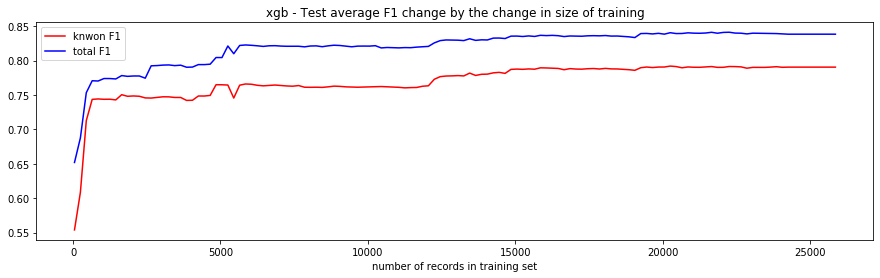

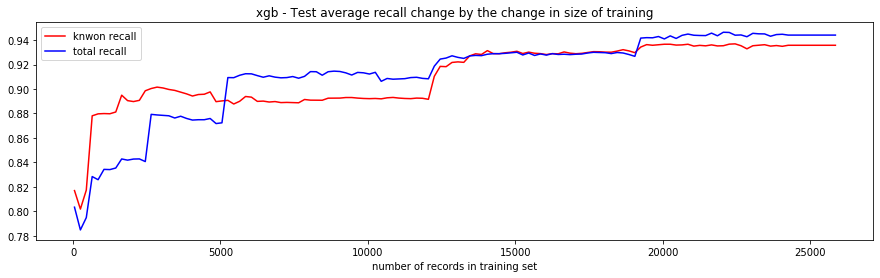

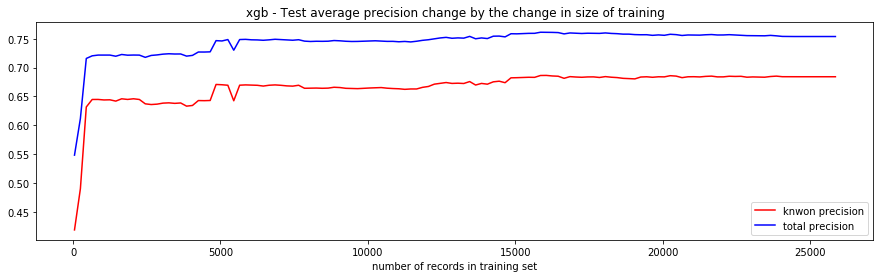

In [12]:

counts = [x[0] for x in count_eval_results]
known_f1 = [x[2][-1] for x in count_eval_results]
all_f1 = [x[1][-1] for x in count_eval_results]

known_recall = [x[2][1] for x in count_eval_results]
all_recall = [x[1][1] for x in count_eval_results]

known_pres = [x[2][-2] for x in count_eval_results]
all_pres = [x[1][-2] for x in count_eval_results]

plt.figure(figsize=(15,4))
plt.title('xgb - Test average F1 change by the change in size of training')
plt.xlabel('number of records in training set')
plt.plot(counts, known_f1, c='red',  label='knwon F1')
plt.plot(counts, all_f1, c='blue',  label='total F1')

plt.legend()

plt.figure(figsize=(15,4))
plt.title('xgb - Test average recall change by the change in size of training')
plt.xlabel('number of records in training set')

plt.plot(counts, known_recall, c='red',  label='knwon recall')
plt.plot(counts, all_recall, c='blue',  label='total recall')

plt.legend()

plt.figure(figsize=(15,4))
plt.title('xgb - Test average precision change by the change in size of training')
plt.xlabel('number of records in training set')

plt.plot(counts, known_pres, c='red',  label='knwon precision')
plt.plot(counts, all_pres, c='blue',  label='total precision')

plt.legend()



In [10]:
def flatter(inp):
    ret = [inp[0]]
    ret.extend(inp[1])
    ret.extend(inp[2])
    
    return ret

csv_ready = [flatter(x) for x in count_eval_results]

    

In [11]:
import csv 

with open('./outputs/xgb_training_by_row_evaluation-%s.csv' % Mapper, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['#training','acc','recall','precision','f1','known_acc','knwon_recall', 'known_precision','known_f1'])
    writer.writerows(csv_ready)